# Fast Product Image Classification (Transfer Learning, MobileNetV2)

This notebook trains a **compact transfer learning model** for product-like images:

1. Using **MobileNetV2** (lightweight ImageNet backbone).
2. Loading a **Fashion-MNIST** as a public fallback.
3. **Subsampling** the dataset and using a **small input size (128)**.
4. Training for just a **few epochs** with early stopping.


In [1]:
import os, math, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt, warnings
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
tf.keras.utils.set_random_seed(SEED)
warnings.filterwarnings("ignore")
print('TensorFlow:', tf.__version__)

TensorFlow: 2.20.0


## Dataset loader
Fashion-MNIST fallback.
**subsample** to speed up training.

Dataset: fashion-mnist | Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


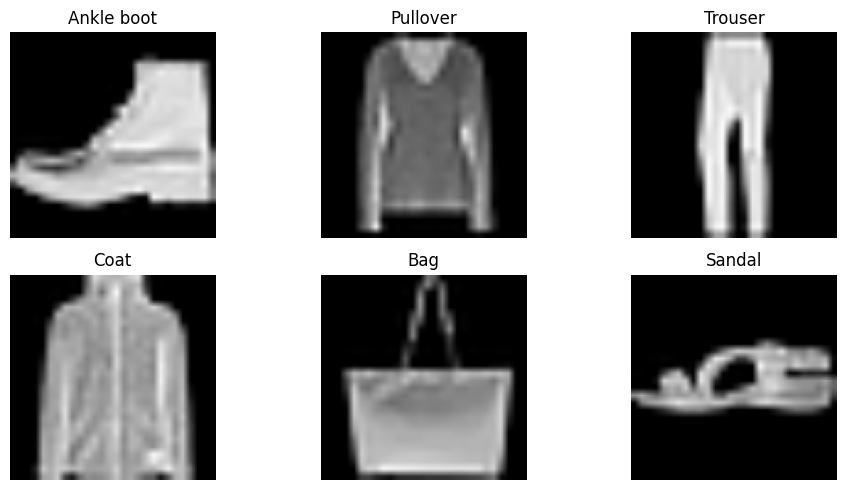

2025-09-04 22:06:18.408780: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
IMG_SIZE = 128
BATCH_SIZE = 64
TRAIN_MAX = 4000  # cap samples for quick run
VAL_MAX = 1000

def load_fashion_mnist(img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    (x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, -1).astype('float32')  # 0..255
    x_val   = np.expand_dims(x_val,   -1).astype('float32')
    # Resize to IMG_SIZE and make 3 channels
    x_train = tf.image.resize(x_train, (img_size, img_size))
    x_val   = tf.image.resize(x_val,   (img_size, img_size))
    x_train = tf.repeat(x_train, 3, axis=-1)
    x_val   = tf.repeat(x_val,   3, axis=-1)
    # Subsample
    rng = np.random.default_rng(SEED)
    tr_idx = rng.choice(len(x_train), size=min(TRAIN_MAX, len(x_train)), replace=False)
    va_idx = rng.choice(len(x_val),   size=min(VAL_MAX,   len(x_val)),   replace=False)
    x_train, y_train = tf.gather(x_train, tr_idx), tf.gather(y_train, tr_idx)
    x_val,   y_val   = tf.gather(x_val,   va_idx), tf.gather(y_val,   va_idx)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000, seed=SEED).batch(batch_size)
    val_ds   = tf.data.Dataset.from_tensor_slices((x_val,   y_val)).batch(batch_size)
    class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat', 'Sandal','Shirt','Sneaker','Bag','Ankle boot']
    return train_ds, val_ds, class_names, 'fashion-mnist'

train_raw, val_raw, CLASS_NAMES, DATASET_KIND = load_fashion_mnist()
NUM_CLASSES = len(CLASS_NAMES)
print('Dataset:', DATASET_KIND, '| Classes:', CLASS_NAMES)

for images, labels in train_raw.take(1):
    plt.figure(figsize=(10,5))
    for i in range(6):  # show 6 examples
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[int(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Preprocessing + MobileNetV2 head (tiny & fast)

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

def prep(ds):
    return ds.map(lambda x,y: (preprocess(tf.cast(x, tf.float32)), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

train_ds = prep(train_raw)
val_ds   = prep(val_raw)

base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", name="conv_last")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_last (Conv2D)              │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,733,962 (14.24 MB)

 Trainable params: 1,475,978 (5.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Quick training

In [4]:
ckpt_path = 'mobilenetv2_products_fast.keras'
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cbs, verbose=1)
print('Saved best model to', ckpt_path)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.7495 - loss: 0.7963 - val_accuracy: 0.8370 - val_loss: 0.4462
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8725 - loss: 0.3668 - val_accuracy: 0.8520 - val_loss: 0.4043
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8978 - loss: 0.2878 - val_accuracy: 0.8520 - val_loss: 0.3920
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9100 - loss: 0.2344 - val_accuracy: 0.8510 - val_loss: 0.3879
Saved best model to mobilenetv2_products_fast.keras


## Evaluate

Val accuracy: 0.852
              precision    recall  f1-score   support

 T-shirt/top      0.872     0.723     0.791        94
     Trouser      1.000     0.951     0.975       103
    Pullover      0.845     0.838     0.841       117
       Dress      0.758     0.892     0.820       102
        Coat      0.718     0.840     0.774       100
      Sandal      0.948     0.948     0.948        96
       Shirt      0.596     0.510     0.549       104
     Sneaker      0.923     0.933     0.928        90
         Bag      0.952     0.971     0.961       102
  Ankle boot      0.945     0.935     0.940        92

    accuracy                          0.852      1000
   macro avg      0.856     0.854     0.853      1000
weighted avg      0.853     0.852     0.850      1000



2025-09-04 22:06:48.223828: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


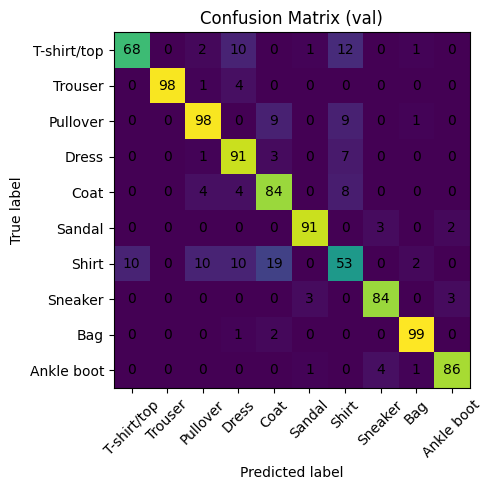

In [5]:
y_true, y_pred = [], []
for xb, yb in val_ds:
    pb = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(pb, axis=1).tolist())
from sklearn.metrics import classification_report, confusion_matrix
print('Val accuracy:', (np.array(y_true) == np.array(y_pred)).mean())
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title('Confusion Matrix (val)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation=45)
plt.yticks(ticks=np.arange(len(CLASS_NAMES)), labels=CLASS_NAMES)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha='center', va='center')
plt.tight_layout(); plt.show()

## Sample predictions (visual check)

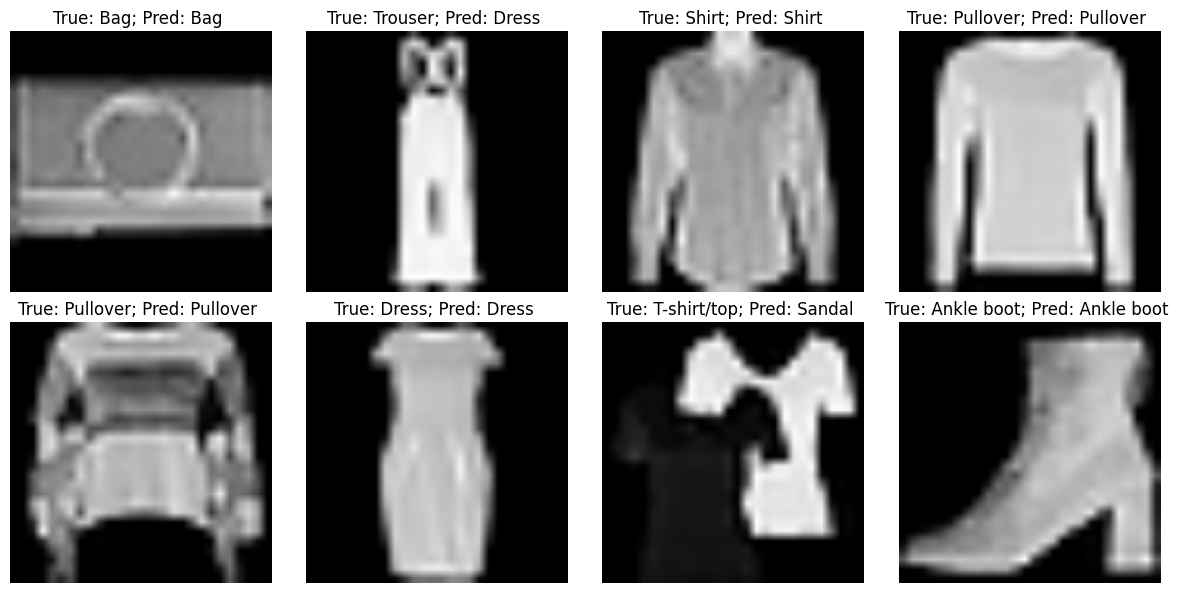

In [6]:
def show_samples(ds, n=6):
    imgs, labs = [], []
    for xb, yb in ds.take(1):
        imgs = xb.numpy()
        labs = yb.numpy()
    if len(imgs) == 0:
        return
    p = model.predict(imgs, verbose=0)
    preds = np.argmax(p, axis=1)
    n = min(n, len(imgs))
    plt.figure(figsize=(12,6))
    for i in range(n):
        plt.subplot(2, int(math.ceil(n/2)), i+1)
        plt.imshow((imgs[i]+1)/2 if imgs[i].min()<0 else imgs[i])
        plt.axis('off')
        plt.title(f"True: {CLASS_NAMES[int(labs[i])]}; Pred: {CLASS_NAMES[int(preds[i])]} ")
    plt.tight_layout(); plt.show()

show_samples(val_ds, n=8)

## (Optional) Grad‑CAM for a few images

2025-09-04 22:06:48.611004: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.91091835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.91091835].


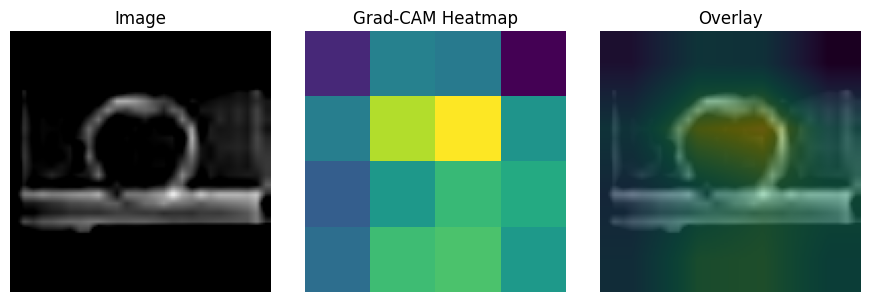

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9922967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9922967].


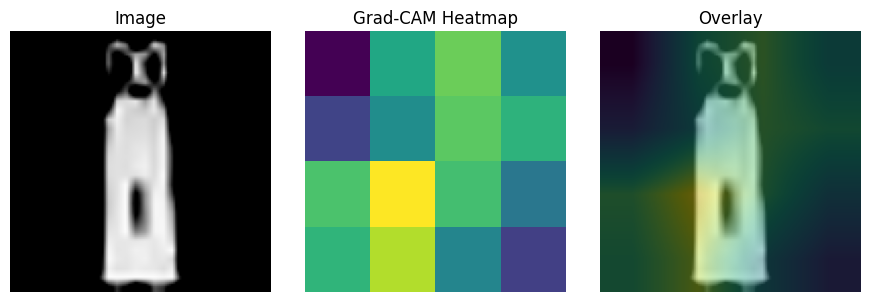

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.87536764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.87536764].


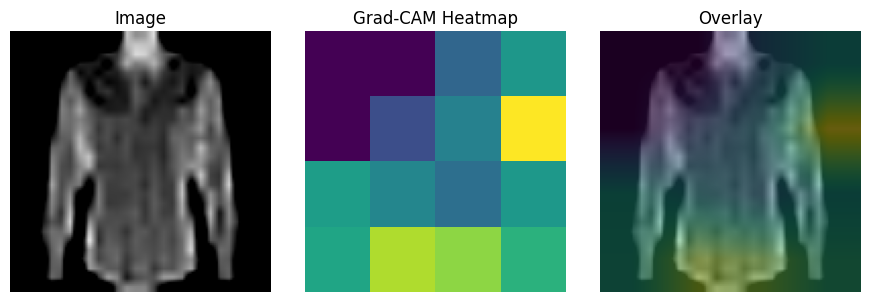

In [7]:
def get_last_conv_name(m):
    try:
        m.get_layer('conv_last')
        return 'conv_last'
    except Exception:
        for layer in reversed(m.layers):
            if isinstance(layer, layers.Conv2D):
                return layer.name
        return None

def grad_cam_single(img, model, last_conv_layer_name):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = keras.Model([model.inputs], [last_conv_layer.output, model.output])
    img_batch = tf.expand_dims(img, axis=0)
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch)
        class_index = tf.argmax(preds[0])
        class_channel = preds[:, class_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(class_index.numpy())

def show_gradcam(ds, n=3):
    LAST_CONV = get_last_conv_name(model)
    if LAST_CONV is None:
        print('No Conv2D layer found for Grad‑CAM.')
        return
    for xb, yb in ds.take(1):
        imgs = xb.numpy(); labs = yb.numpy()
    n = min(n, len(imgs))
    for i in range(n):
        img = imgs[i]
        heat, pred_class = grad_cam_single(img, model, LAST_CONV)
        up = tf.image.resize(heat[...,None], img.shape[:2]).numpy().squeeze()
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
        plt.subplot(1,3,2); plt.imshow(heat); plt.axis('off'); plt.title('Grad‑CAM Heatmap')
        plt.subplot(1,3,3); plt.imshow(img); plt.imshow(up, alpha=0.4); plt.axis('off'); plt.title('Overlay')
        plt.tight_layout(); plt.show()

show_gradcam(val_ds, n=3)